In [2]:
from dolfin import *
import numpy as np 

ENABLE_TRANS = True

LENGTH = 1.0
WIDTH = 0.2
HIGHT = 0.1

LAMA_MU = 1.0
LAMA_LAMBDA = 1.25

E = LAMA_MU*(3*LAMA_LAMBDA+2*LAMA_MU)/(LAMA_MU+LAMA_LAMBDA)
nu = LAMA_LAMBDA/2.0/(LAMA_MU+LAMA_LAMBDA)

# 二维正交各向异性
E1, E2, mu12, G12 = 130000, 7700, 0.33, 4800

# 转动角度
Theta = 45

# 弹性矩阵
C2D_Aniso = np.array([
    [E/(1-nu**2)   ,   nu*E/(1-nu**2),  0           ],
    [nu*E/(1-nu**2),   E/(1-nu**2)   ,  0           ],
    [0             ,   0             ,  E/2.0/(1+nu)]
])

C2D_Iso = np.array([
    [E1/(1-mu12**2), mu12*E2/(1-mu12**2), 0],
    [mu12*E2/(1-mu12**2), E2/(1-mu12**2), 0],
    [0, 0, G12]
])

# 转轴公式
def T2D_inv(theta):
    theta = theta * np.pi / 180.0
    Trans = np.array([
        [np.cos(theta)**2, np.sin(theta)**2, -2*np.sin(theta)*np.cos(theta)],
        [np.sin(theta)**2, np.cos(theta)**2, 2*np.sin(theta)*np.cos(theta)],
        [np.sin(theta)*np.cos(theta), -np.sin(theta)*np.cos(theta), np.cos(theta)**2-np.sin(theta)**2]
    ])
    return Trans

In [3]:
# a = np.array([[1,2,3],
#               [4,5,6],
#               [7,8,9]])
# b = np.array([1,1,1])
# print(np.dot(a,b))

In [4]:
# 定义本构
# translate
def epsilon(u):
    engineering_strain = 0.5 * (nabla_grad(u) + nabla_grad(u).T)
    return engineering_strain

def sigma(u):
    cauchy_stress = LAMA_LAMBDA * tr(epsilon(u))*Identity(2) + 2 * LAMA_MU * epsilon(u)
    return cauchy_stress

def sigma_tensor(u):
    # 计算应变张量
    epsilon_ij = epsilon(u)
    ep = as_vector([epsilon_ij[0,0], epsilon_ij[1,1], epsilon_ij[0,1]])
    # 使用弹性系数计算应力张量
    if ENABLE_TRANS:
        Q_bar = np.dot(np.dot(T2D_inv(Theta), C2D_Iso), T2D_inv(Theta).T)
    else:
        Q_bar = C2D_Iso
    print(Q_bar)
    print(np.linalg.inv(Q_bar))
    sigma_ij = np.dot(Q_bar, ep)
    
    return as_tensor([[sigma_ij[0], sigma_ij[2]],
                      [sigma_ij[2], sigma_ij[1]]])

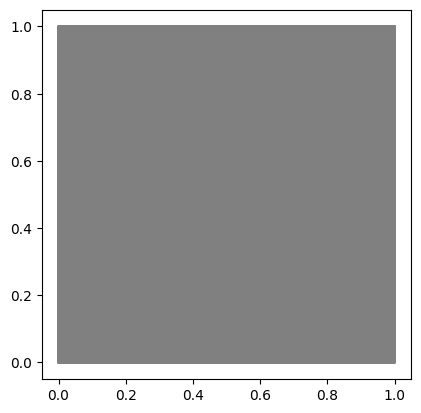

In [5]:
# 创建网格并显示
mesh = UnitSquareMesh(300, 300) 
# mesh = UnitCubeMesh(30, 30)
V = VectorFunctionSpace(mesh, "Lagrange", 1)
plot(mesh)

In [6]:
# 狄利克雷边界
def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < DOLFIN_EPS

bc = DirichletBC(V, Constant((0.0, 0.0)), clamped_boundary)

# 自然边界
class RightEnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 1) < DOLFIN_EPS and (abs(x[1] - 0.5) < 0.5)
right_end_boundary = RightEnd()

class TopEnd(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 0.5) < 0.1 and (abs(x[1] - 1) < DOLFIN_EPS)
top_end_boundary = TopEnd()

boundary_mark = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundary_mark.set_all(0)
right_end_boundary.mark(boundary_mark, 1)
top_end_boundary.mark(boundary_mark, 2)

# expression = Expression(Constant((0.0, 0.2)), degree=2)
# expression = Constant((0.0, 1.0))
# u_ex = project(expression, V
# plot(u_ex, title="forcing vectors")

In [7]:
u_trial = TrialFunction(V)
v_test = TestFunction(V)

In [8]:
forcing = Constant((500, 0))
forcing2 = Constant((0, 0))

In [9]:
lhs = inner(sigma_tensor(u_trial), nabla_grad(v_test)) * dx
# rhs = dot(forcing, v_test) * dx
rhs = (dot(forcing, v_test) * ds(subdomain_data=boundary_mark, domain=mesh, subdomain_id=1)
       +
       dot(forcing2, v_test) * ds(subdomain_data=boundary_mark, domain=mesh, subdomain_id=2))
# rhs = dot(forcing, v_test) * dx


# plot(rhs)

[[44857.79373808 35257.79373808 34311.52508136]
 [35257.79373808 44857.79373808 34311.52508136]
 [34311.52508136 34311.52508136 37206.26192347]]
[[ 8.17894048e-05 -2.23772618e-05 -5.47897351e-05]
 [-2.23772618e-05  8.17894048e-05 -5.47897351e-05]
 [-5.47897351e-05 -5.47897351e-05  1.27931120e-04]]


Solving linear variational problem.
181202
0.076105221368294
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.00027494 -0.00048559]
 ...
 [ 0.03756284 -0.05377108]
 [ 0.03794927 -0.05417664]
 [ 0.03756092 -0.05417472]]


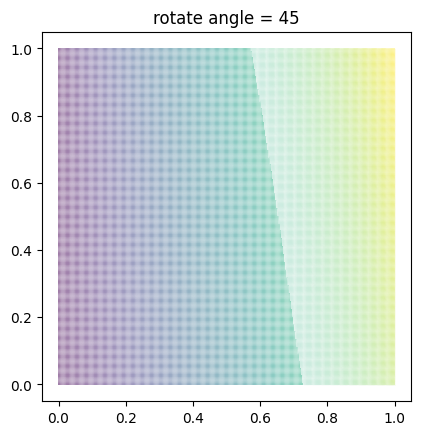

In [10]:
u_solution = Function(V)

problem = LinearVariationalProblem(lhs, rhs, u_solution, bcs=[bc])
solver = LinearVariationalSolver(problem)
solver.solve()

plot(u_solution,
     title = "rotate angle = " + str(Theta))
count_u_rows = u_solution.vector()[:].shape[0]
print(count_u_rows)
a = u_solution.vector()[:].reshape(int(count_u_rows/2), 2)
b = np.linalg.norm(a, axis=1)
print(b.max())

print(a)

In [18]:
a = np.array([[1,2,3],
              [4,5,6],
              [7,8,9]])
as_tensor = as_tensor(a)
b = as_tensor([[1,1,1],
               [1,1,1],
               [1,1,1]])
# print(a)
# b = as_vector([1,1,1])
inner_product = inner(a,b)
print(inner_product)

UFLValueError: Invalid type conversion: 1 can not be converted to any UFL type.